### Preparation

In [22]:
import tqdm
import os
import cv2
import imghdr
import image_to_numpy
import numpy as np
import seaborn as sns
from matplotlib import pyplot as plt
from datetime import datetime
import itertools

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import RandomFlip, RandomRotation, RandomContrast, RandomBrightness, Rescaling, Resizing
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization, ReLU
from tensorflow.keras.metrics import F1Score, Precision, Recall, CategoricalAccuracy

import sklearn
from sklearn.metrics import classification_report,confusion_matrix

In [2]:
data_dir = 'D:\DATASETS\For-Thesis\Labels'

In [3]:
def sample_count(data_dir):
    for dir in os.listdir(data_dir):
        print("{}: {}".format(dir, len(os.listdir(os.path.join(data_dir,dir)))))

In [4]:
sample_count(data_dir)

Building: 600
Plant: 600
Road: 600
Vehicle: 600


### Prepare Dataset

In [5]:
labels = ['Building', 'Plant', 'Road', 'Vehicle']
X_train = []
y_train = []
y_label_idx = []
image_size = 256
for i in labels:
    folderPath = os.path.join('D:\DATASETS\For-Thesis\Labels', i)
    for j in os.listdir(folderPath):
        img = image_to_numpy.load_image_file(os.path.join(folderPath,j))
        img = cv2.resize(img,(image_size, image_size))
        X_train.append(img)
        y_label_idx.append(labels.index(i))

In [6]:
X_train = np.array(X_train)
y_label_idx = np.array(y_label_idx)

X_train_scaled = X_train.astype(np.float32) / 255.0
y_one_hot = tf.keras.utils.to_categorical(y_label_idx)

In [7]:
y_one_hot[0]

array([1., 0., 0., 0.], dtype=float32)

In [8]:
dataset = tf.data.Dataset.from_tensor_slices((X_train_scaled, y_one_hot))
dataset = dataset.shuffle(buffer_size=dataset.cardinality(), seed=1).batch(8)

In [9]:
dataset_iter = dataset.as_numpy_iterator()

In [10]:
batch = dataset_iter.next()

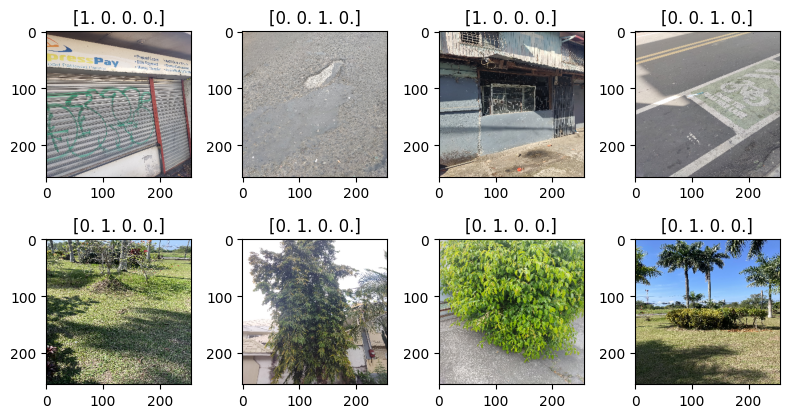

In [14]:
fig, ax = plt.subplots(ncols=4, nrows=2, figsize=(8,4.5))
for idx, ax_idx in enumerate(itertools.product(range(2),range(4))):
    ax[ax_idx].imshow(batch[0][idx].astype(float))
    ax[ax_idx].title.set_text(batch[1][idx])
    
fig.tight_layout()
plt.subplots_adjust(hspace=0.1)
plt.show()

In [15]:
total_batch_count = len(dataset) 
train_batch_count = total_batch_count // 4 * 3  # 75% of batches
test_batch_count = total_batch_count - train_batch_count
print(total_batch_count , train_batch_count, test_batch_count)

300 225 75


In [16]:
train_size, test_size = train_batch_count, test_batch_count
train_set = dataset.take(train_size)
test_set = dataset.skip(train_size).take(test_size)

In [17]:
train_set, val_set = tf.keras.utils.split_dataset(dataset=train_set, left_size=0.75, shuffle=True, seed=1)

### Make Model

In [84]:
model = Sequential()
model.add(RandomFlip(mode='horizontal', seed=1, input_shape=(256,256,3)))
model.add(RandomRotation(factor=0.2, seed=1))

model.add(Conv2D(input_shape=(256,256,3), filters=16, kernel_size=(3,3), padding="same"))
model.add(BatchNormalization())
model.add(ReLU())
model.add(MaxPooling2D())

model.add(Conv2D(filters=32, kernel_size=(3,3), padding="same"))
model.add(BatchNormalization())
model.add(ReLU())
model.add(MaxPooling2D())

model.add(Conv2D(filters=32, kernel_size=(3,3), padding="same"))
model.add(BatchNormalization())
model.add(ReLU())
model.add(MaxPooling2D())

model.add(Flatten())
model.add(Dropout(0.2, seed=1))
model.add(Dense(units=96,activation="relu"))
model.add(Dense(units=96,activation="relu"))

model.add(Dense(units=4, activation="softmax"))
model.compile('adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [85]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 random_flip_2 (RandomFlip)  (None, 256, 256, 3)       0         
                                                                 
 random_rotation_2 (RandomR  (None, 256, 256, 3)       0         
 otation)                                                        
                                                                 
 conv2d_6 (Conv2D)           (None, 256, 256, 16)      448       
                                                                 
 batch_normalization_6 (Bat  (None, 256, 256, 16)      64        
 chNormalization)                                                
                                                                 
 re_lu_6 (ReLU)              (None, 256, 256, 16)      0         
                                                                 
 max_pooling2d_6 (MaxPoolin  (None, 128, 128, 16)     

In [86]:
file_name = 'Model_V4-0-2_' + datetime.now().strftime("%Y%m%d-%H%M%S")
log_dir = f'./logs/{file_name}'
checkpoint_filepath = f'./checkpoints/{file_name}'

tb_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, 
                                             histogram_freq=1,
                                             profile_batch=2,
                                             write_graph=True,
                                             write_images=True,
                                             update_freq='epoch',
                                             embeddings_freq=1
                                            )
es_callback = tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', 
                                               patience=5)
cp_callback = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_filepath, 
                                                         monitor='val_accuracy', 
                                                         mode='auto', 
                                                         save_best_only=True, 
                                                         verbose=1)
reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_accuracy', 
                                                 factor=0.3, 
                                                 patience=2, 
                                                 min_delta=0.001, 
                                                 mode='auto', 
                                                 verbose=1)

### Train and Inspect Model

In [87]:
hist = model.fit(train_set, 
                 validation_data=val_set, 
                 epochs=35,
                 verbose=1,
                 callbacks=[tb_callback, es_callback, cp_callback, reduce_lr])

Epoch 1/35
169/169 [==============================] - ETA: 0s - loss: 1.7902 - accuracy: 0.5821
Epoch 1: val_accuracy improved from -inf to 0.30134, saving model to ./checkpoints\Model_V4-0-2_20240301-132612
INFO:tensorflow:Assets written to: ./checkpoints\Model_V4-0-2_20240301-132612\assets


INFO:tensorflow:Assets written to: ./checkpoints\Model_V4-0-2_20240301-132612\assets


169/169 [==============================] - 59s 324ms/step - loss: 1.7902 - accuracy: 0.5821 - val_loss: 1.8914 - val_accuracy: 0.3013 - lr: 0.0010
Epoch 2/35
169/169 [==============================] - ETA: 0s - loss: 0.8125 - accuracy: 0.7160
Epoch 2: val_accuracy improved from 0.30134 to 0.45982, saving model to ./checkpoints\Model_V4-0-2_20240301-132612
INFO:tensorflow:Assets written to: ./checkpoints\Model_V4-0-2_20240301-132612\assets


INFO:tensorflow:Assets written to: ./checkpoints\Model_V4-0-2_20240301-132612\assets


169/169 [==============================] - 47s 279ms/step - loss: 0.8125 - accuracy: 0.7160 - val_loss: 1.2935 - val_accuracy: 0.4598 - lr: 0.0010
Epoch 3/35
169/169 [==============================] - ETA: 0s - loss: 0.6653 - accuracy: 0.7596
Epoch 3: val_accuracy improved from 0.45982 to 0.54018, saving model to ./checkpoints\Model_V4-0-2_20240301-132612
INFO:tensorflow:Assets written to: ./checkpoints\Model_V4-0-2_20240301-132612\assets


INFO:tensorflow:Assets written to: ./checkpoints\Model_V4-0-2_20240301-132612\assets


169/169 [==============================] - 47s 278ms/step - loss: 0.6653 - accuracy: 0.7596 - val_loss: 1.9640 - val_accuracy: 0.5402 - lr: 0.0010
Epoch 4/35
169/169 [==============================] - ETA: 0s - loss: 0.6246 - accuracy: 0.7559
Epoch 4: val_accuracy improved from 0.54018 to 0.54688, saving model to ./checkpoints\Model_V4-0-2_20240301-132612
INFO:tensorflow:Assets written to: ./checkpoints\Model_V4-0-2_20240301-132612\assets


INFO:tensorflow:Assets written to: ./checkpoints\Model_V4-0-2_20240301-132612\assets


169/169 [==============================] - 47s 277ms/step - loss: 0.6246 - accuracy: 0.7559 - val_loss: 1.6136 - val_accuracy: 0.5469 - lr: 0.0010
Epoch 5/35
169/169 [==============================] - ETA: 0s - loss: 0.5187 - accuracy: 0.7936
Epoch 5: val_accuracy improved from 0.54688 to 0.72098, saving model to ./checkpoints\Model_V4-0-2_20240301-132612
INFO:tensorflow:Assets written to: ./checkpoints\Model_V4-0-2_20240301-132612\assets


INFO:tensorflow:Assets written to: ./checkpoints\Model_V4-0-2_20240301-132612\assets


169/169 [==============================] - 48s 281ms/step - loss: 0.5187 - accuracy: 0.7936 - val_loss: 0.6592 - val_accuracy: 0.7210 - lr: 0.0010
Epoch 6/35
169/169 [==============================] - ETA: 0s - loss: 0.5073 - accuracy: 0.8062
Epoch 6: val_accuracy did not improve from 0.72098
169/169 [==============================] - 42s 251ms/step - loss: 0.5073 - accuracy: 0.8062 - val_loss: 1.1481 - val_accuracy: 0.5826 - lr: 0.0010
Epoch 7/35
169/169 [==============================] - ETA: 0s - loss: 0.4656 - accuracy: 0.8151
Epoch 7: val_accuracy did not improve from 0.72098

Epoch 7: ReduceLROnPlateau reducing learning rate to 0.0003000000142492354.
169/169 [==============================] - 43s 253ms/step - loss: 0.4656 - accuracy: 0.8151 - val_loss: 1.7137 - val_accuracy: 0.5268 - lr: 0.0010
Epoch 8/35
169/169 [==============================] - ETA: 0s - loss: 0.3560 - accuracy: 0.8624
Epoch 8: val_accuracy improved from 0.72098 to 0.76562, saving model to ./checkpoints\Model_

INFO:tensorflow:Assets written to: ./checkpoints\Model_V4-0-2_20240301-132612\assets


169/169 [==============================] - 50s 296ms/step - loss: 0.3560 - accuracy: 0.8624 - val_loss: 0.6212 - val_accuracy: 0.7656 - lr: 3.0000e-04
Epoch 9/35
169/169 [==============================] - ETA: 0s - loss: 0.3285 - accuracy: 0.8661
Epoch 9: val_accuracy improved from 0.76562 to 0.80357, saving model to ./checkpoints\Model_V4-0-2_20240301-132612
INFO:tensorflow:Assets written to: ./checkpoints\Model_V4-0-2_20240301-132612\assets


INFO:tensorflow:Assets written to: ./checkpoints\Model_V4-0-2_20240301-132612\assets


169/169 [==============================] - 47s 278ms/step - loss: 0.3285 - accuracy: 0.8661 - val_loss: 0.5072 - val_accuracy: 0.8036 - lr: 3.0000e-04
Epoch 10/35
169/169 [==============================] - ETA: 0s - loss: 0.2838 - accuracy: 0.8928
Epoch 10: val_accuracy did not improve from 0.80357
169/169 [==============================] - 42s 250ms/step - loss: 0.2838 - accuracy: 0.8928 - val_loss: 0.6175 - val_accuracy: 0.7812 - lr: 3.0000e-04
Epoch 11/35
169/169 [==============================] - ETA: 0s - loss: 0.2800 - accuracy: 0.8920
Epoch 11: val_accuracy did not improve from 0.80357

Epoch 11: ReduceLROnPlateau reducing learning rate to 9.000000427477062e-05.
169/169 [==============================] - 42s 249ms/step - loss: 0.2800 - accuracy: 0.8920 - val_loss: 0.6956 - val_accuracy: 0.7656 - lr: 3.0000e-04
Epoch 12/35
169/169 [==============================] - ETA: 0s - loss: 0.2215 - accuracy: 0.9157
Epoch 12: val_accuracy did not improve from 0.80357
169/169 [=============

INFO:tensorflow:Assets written to: ./checkpoints\Model_V4-0-2_20240301-132612\assets


169/169 [==============================] - 47s 278ms/step - loss: 0.2370 - accuracy: 0.9120 - val_loss: 0.5056 - val_accuracy: 0.8371 - lr: 9.0000e-05
Epoch 14/35
169/169 [==============================] - ETA: 0s - loss: 0.2253 - accuracy: 0.9231
Epoch 14: val_accuracy did not improve from 0.83705
169/169 [==============================] - 42s 249ms/step - loss: 0.2253 - accuracy: 0.9231 - val_loss: 0.5031 - val_accuracy: 0.8304 - lr: 9.0000e-05
Epoch 15/35
169/169 [==============================] - ETA: 0s - loss: 0.2194 - accuracy: 0.9157
Epoch 15: val_accuracy did not improve from 0.83705

Epoch 15: ReduceLROnPlateau reducing learning rate to 2.700000040931627e-05.
169/169 [==============================] - 42s 249ms/step - loss: 0.2194 - accuracy: 0.9157 - val_loss: 0.5576 - val_accuracy: 0.8170 - lr: 9.0000e-05
Epoch 16/35
169/169 [==============================] - ETA: 0s - loss: 0.2076 - accuracy: 0.9201
Epoch 16: val_accuracy did not improve from 0.83705
169/169 [=============

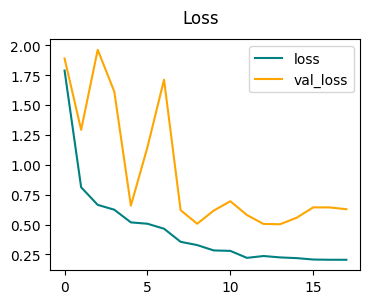

In [88]:
fig = plt.figure(figsize=(4,3))
plt.plot(hist.history['loss'], color='teal', label='loss')
plt.plot(hist.history['val_loss'], color='orange', label='val_loss')
plt.suptitle('Loss')
plt.legend(loc='upper right')
plt.show()

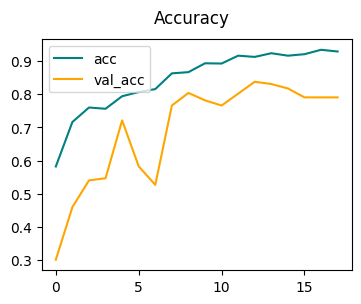

In [89]:
fig = plt.figure(figsize=(4,3))
plt.plot(hist.history['accuracy'], color='teal', label='acc')
plt.plot(hist.history['val_accuracy'], color='orange', label='val_acc')
plt.suptitle('Accuracy')
plt.legend(loc='upper left')
plt.show()

### Evaluate Last Case of Model

In [90]:
f1 = F1Score()
pre = Precision()
rec = Recall()
c_acc = CategoricalAccuracy()

In [91]:
for batch in test_set.as_numpy_iterator():
    X, y = batch
    yhat = model.predict(X)
    f1.update_state(y, yhat)
    pre.update_state(y, yhat)
    rec.update_state(y, yhat)
    c_acc.update_state(y, yhat)

1/1 [==============================] - 0s 96ms/step


In [92]:
def print_scores(f1, pre, rec, c_acc):
    f1_score = f1.result().numpy() * 100
    pre_score = pre.result().numpy() * 100
    rec_score = rec.result().numpy() * 100
    c_acc_score = c_acc.result().numpy() * 100
    print(f"Precision: {pre_score:.2f}")
    print(f"Recall: {rec_score:.2f}")
    print(f"Categorical Accuracy: {c_acc_score:.2f}")
    print("F1 Score: ", f1_score)

In [93]:
print_scores(f1, pre, rec, c_acc)

Precision: 84.19
Recall: 81.67
Categorical Accuracy: 82.50
F1 Score:  [76.28866 85.53055 90.65155 74.28571]


### More Visualization (Tensorboard)

In [ ]:
# Load the TensorBoard notebook extension
%load_ext tensorboard

import datetime

In [ ]:
test_log = 'logs/test'
img_dir = "D:\\DATASETS\\Car-Plant-House-Road-Dataset\\Sample-Thesis-Dataset\\2.png"

file_writer = tf.summary.create_file_writer(test_log)
img = image_to_numpy.load_image_file(os.path.join(img_dir))
img = cv2.resize(img, (256, 256))
img = np.reshape(img, (-1, 256, 256, 3))

In [ ]:
# Using the file writer, log the reshaped image.
with file_writer.as_default():
  tf.summary.image("Training data", img, step=0)

In [ ]:
# AppData/Local/Temp/.tensorboard-info - delete folder if it cannot load
%tensorboard --logdir=logs/

### Load Best Model from Checkpoint and Evaluate

In [94]:
saved_model = tf.keras.models.load_model("checkpoints\\Model_V4-0-2_20240301-132612")

In [95]:
saved_model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 random_flip_2 (RandomFlip)  (None, 256, 256, 3)       0         
                                                                 
 random_rotation_2 (RandomR  (None, 256, 256, 3)       0         
 otation)                                                        
                                                                 
 conv2d_6 (Conv2D)           (None, 256, 256, 16)      448       
                                                                 
 batch_normalization_6 (Bat  (None, 256, 256, 16)      64        
 chNormalization)                                                
                                                                 
 re_lu_6 (ReLU)              (None, 256, 256, 16)      0         
                                                                 
 max_pooling2d_6 (MaxPoolin  (None, 128, 128, 16)     

In [96]:
best_result = saved_model.evaluate(test_set, return_dict=True, verbose=2)
print(best_result)

75/75 - 4s - loss: 0.4149 - accuracy: 0.8633 - 4s/epoch - 58ms/step
{'loss': 0.41487425565719604, 'accuracy': 0.8633333444595337}


In [97]:
f1 = F1Score()
pre = Precision()
rec = Recall()
c_acc = CategoricalAccuracy()

In [98]:
test_labels = []
test_preds = []


In [99]:
for batch in test_set.as_numpy_iterator():
    X, y = batch
    yhat = saved_model.predict(X)
    f1.update_state(y, yhat)
    pre.update_state(y, yhat)
    rec.update_state(y, yhat)
    c_acc.update_state(y, yhat)
    
    for i in range(len(y)):
        test_labels.append(y[i])
        test_preds.append(yhat[i])

1/1 [==============================] - 0s 125ms/step


In [100]:
print_scores(f1, pre, rec, c_acc)

Precision: 87.16
Recall: 84.83
Categorical Accuracy: 86.17
F1 Score:  [80.134674 89.29663  93.37539  80.30888 ]


###  Plotting Confusion Matrix 

In [101]:
test_labels = np.array(test_labels)
test_preds = np.array(test_preds)

In [102]:
test_labels_c = [np.argmax(x) for x in test_labels]
test_labels_c = np.array(test_labels_c)

test_preds_c = [np.argmax(x) for x in test_preds]
test_preds_c = np.array(test_preds_c)


In [103]:
test_labels_c[:5]

array([1, 3, 3, 1, 0], dtype=int64)

In [104]:
test_labels[:5]

array([[0., 1., 0., 0.],
       [0., 0., 0., 1.],
       [0., 0., 0., 1.],
       [0., 1., 0., 0.],
       [1., 0., 0., 0.]], dtype=float32)

In [105]:
cm = sklearn.metrics.confusion_matrix(test_labels_c, test_preds_c)

Text(0.5, 1.0, 'Confusion Matrix')

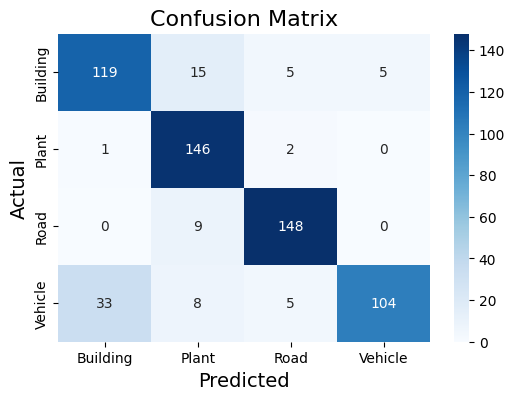

In [106]:
fig, ax = plt.subplots(figsize=(6,4))
sns.heatmap(cm, annot=True, cmap="Blues", cbar=True,
            xticklabels=['Building', 'Plant', 'Road', 'Vehicle'],
            yticklabels=['Building', 'Plant', 'Road', 'Vehicle'],
            fmt='g'
           )
plt.xlabel('Predicted', fontsize=14)
plt.ylabel('Actual', fontsize=14)
plt.title('Confusion Matrix', fontsize=16)

## Save Model For API

In [ ]:
# saved_model = tf.keras.models.load_model('checkpoints\\Model_V4-0-0')

In [107]:
saved_model.save("models/Model_V4-0-2_20240301-132612.keras")

## See what the model sees

In [ ]:
saved_model.summary()

In [ ]:
len(saved_model.layers)

In [ ]:
layers_c1 = saved_model.layers[:6]
model_c1 = Sequential(layers_c1)
model_c1.summary()

In [ ]:
img_sample_dir = "D:\\DATASETS\\For-Thesis\\From Other Datasets\\Stanford-Car-Dataset\\cars_train\\cars_train\\00006.jpg"

In [ ]:
model_c1.input_shape

In [ ]:
image_size = 256
img_sample = image_to_numpy.load_image_file(os.path.join(img_sample_dir))
img_sample = cv2.resize(img_sample, (image_size, image_size))
img_sample = img_sample.astype(np.float32) / 255.0

In [ ]:
fig, ax = plt.subplots(figsize=(3,3))
ax.imshow(img_sample.astype(float))

In [ ]:
output_c1 = model_c1.predict(np.expand_dims(img_sample, 0))

In [ ]:
output_c1[0,:,:,0].shape

In [ ]:
def viz_grid(output, ncols=4, nrows=4):
    fig, ax = plt.subplots(ncols=ncols, nrows=nrows, figsize=(10,10))
    # itertools.product creates a permutation 
    for idx, ax_idx in enumerate(list(itertools.product(range(ncols), range(nrows)))):
        ax[ax_idx[1], ax_idx[0]].imshow(output[0,:,:,idx])

In [ ]:
viz_grid(output_c1, 4, 4)

In [ ]:
layers_c2 = saved_model.layers[:10]
model_c2 = Sequential(layers_c2)
model_c2.summary()

In [ ]:
output_c2 = model_c2.predict(np.expand_dims(img_sample, 0))

In [ ]:
viz_grid(output_c2, 4, 4)

In [ ]:
layers_c3 = saved_model.layers[:14]
model_c3 = Sequential(layers_c3)
model_c3.summary()

In [ ]:
output_c3 = model_c3.predict(np.expand_dims(img_sample, 0))
output_c3.shape

In [ ]:
fig, ax = plt.subplots(ncols=4, nrows=8, figsize=(15,15))
# itertools.product creates a permutation 
for idx, ax_idx in enumerate(list(itertools.product(range(4), range(8)))):
    ax[ax_idx[1], ax_idx[0]].imshow(output_c3[0,:,:,idx])
    
fig.tight_layout()

In [ ]:
yhat = saved_model.predict(np.expand_dims(img_sample, 0))

In [ ]:
# 0 is building
np.argmax(yhat)